###  Libraries Used  
pandas, numpy (data processing) | matplotlib (visualization) | scikit-learn, XGBoost (ML models & metrics) | SMOTE (class imbalance) | networkx (graph analysis) | pickle (model persistence)


In [10]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler      
from sklearn.pipeline import Pipeline                

import xgboost as xgb
from imblearn.over_sampling import SMOTE

plt.style.use("ggplot")


##  Feature Engineering

This function builds model-ready features including:

- **Temporal Features** – hour, day_of_week, weekend flag, month  
- **Transaction Velocity** – rolling 1-hour transaction count per sender  
- **Behavioral Features** – sender mean, std, count, unique receivers, amount z-score  
- **Graph Features** – PageRank and degree centrality using NetworkX  
- **Categorical Encoding** – One-hot encoding for transaction, bank, device, and network features  

Returns a fully processed DataFrame ready for ML training.


In [11]:
def build_features(df):
    
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values(["sender_id", "timestamp"])
    
    # Temporal
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
    df["month"] = df["timestamp"].dt.month
    
    # Velocity (rolling 1h)
    df = df.set_index("timestamp")
    df["txn_velocity_1h"] = (
        df.groupby("sender_id")["amount"]
        .rolling("1h")
        .count()
        .reset_index(level=0, drop=True)
    )
    df = df.reset_index()
    df["txn_velocity_1h"] = df["txn_velocity_1h"].fillna(1)
    
    # Behavioral
    df["sender_mean_amt"] = df.groupby("sender_id")["amount"].transform("mean")
    df["sender_std_amt"] = df.groupby("sender_id")["amount"].transform("std")
    df["sender_txn_count"] = df.groupby("sender_id")["amount"].transform("count")
    df["unique_receivers"] = df.groupby("sender_id")["receiver_id"].transform("nunique")
    
    df["amount_zscore"] = (
        (df["amount"] - df["sender_mean_amt"]) /
        (df["sender_std_amt"] + 1e-5)
    )
    
    # Graph features
    G = nx.from_pandas_edgelist(
        df,
        source="sender_id",
        target="receiver_id",
        create_using=nx.DiGraph()
    )
    
    pagerank = nx.pagerank(G)
    degree = nx.degree_centrality(G)
    
    df["sender_pagerank"] = df["sender_id"].map(pagerank)
    df["sender_degree"] = df["sender_id"].map(degree)
    
    df = df.fillna(0)
    
    # One-hot encoding
    categorical_cols = [
        "transaction_type",
        "merchant_category",
        "sender_state",
        "receiver_state",
        "sender_bank",
        "receiver_bank",
        "device_type",
        "network_type"
    ]
    
    existing = [c for c in categorical_cols if c in df.columns]
    df = pd.get_dummies(df, columns=existing, drop_first=True)
    
    return df


##  Data Loading & Preparation

- Loads the UPI transaction dataset  
- Applies feature engineering (`build_features`)  
- Drops ID, timestamp, and target-leakage columns  
- Splits into **X (features)** and **y (fraud_flag)**  
- Displays fraud rate and total feature count  


In [12]:
df = pd.read_csv("../data/upi_100k_ultra_realistic.csv")
df = build_features(df)

drop_cols = [
    "fraud_flag",
    "transaction_id",
    "timestamp",
    "sender_id",
    "receiver_id"
]

X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = df["fraud_flag"]

print("Fraud Rate:", round(y.mean(),4))
print("Total Features:", X.shape[1])


Fraud Rate: 0.0079
Total Features: 55


##  Train-Test Split & Class Balancing

- Splits data into **80% training** and **20% testing** (stratified by fraud label)  
- Applies **SMOTE** to balance minority fraud class in training data  
- Prints final training shape after resampling  


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print("Training shape after SMOTE:", X_train.shape)


Training shape after SMOTE: (158734, 55)


##  Model Initialization

Defines three classification models for fraud detection:

- **Logistic Regression** – Baseline linear model  
- **Random Forest** – Ensemble tree-based model (300 trees)  
- **XGBoost** – Gradient boosting model with tuned depth, learning rate, and class imbalance handling  


In [14]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=5000))
    ]),
    
    "Random Forest": RandomForestClassifier(n_estimators=300),

    "XGBoost": xgb.XGBClassifier(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.05,
        scale_pos_weight=10,
        eval_metric="auc"
    )
}


##  Model Training & Cost-Based Evaluation

- Trains each model and predicts fraud probabilities  
- Computes **ROC-AUC** and **PR-AUC** for performance evaluation  
- Applies 0.5 decision threshold for classification  
- Calculates **cost-sensitive financial loss**:
  - False Negative (FN) cost = ₹5000  
  - False Positive (FP) cost = ₹200  
- Stores model metrics, predictions, and loss for comparison  


In [15]:
results = {}
C_FN = 5000
C_FP = 200

for name, model in models.items():
    
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = (y_proba > 0.5).astype(int)
    
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    loss = C_FN * fn + C_FP * fp
    
    results[name] = {
        "model": model,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "loss": loss,
        "y_proba": y_proba
    }
    
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC : {pr_auc:.4f}")
    print(f"Financial Loss: ₹{loss:,}")



Training Logistic Regression...
ROC-AUC: 0.9482
PR-AUC : 0.3306
Financial Loss: ₹562,800

Training Random Forest...
ROC-AUC: 0.9857
PR-AUC : 0.5817
Financial Loss: ₹236,000

Training XGBoost...
ROC-AUC: 0.9833
PR-AUC : 0.5588
Financial Loss: ₹183,800


##  ROC Curve Comparison

- Plots ROC curves for all trained models  
- Displays AUC score in legend for comparison  
- Includes diagonal baseline (random classifier)  
- Helps evaluate trade-off between **TPR (Recall)** and **FPR**  


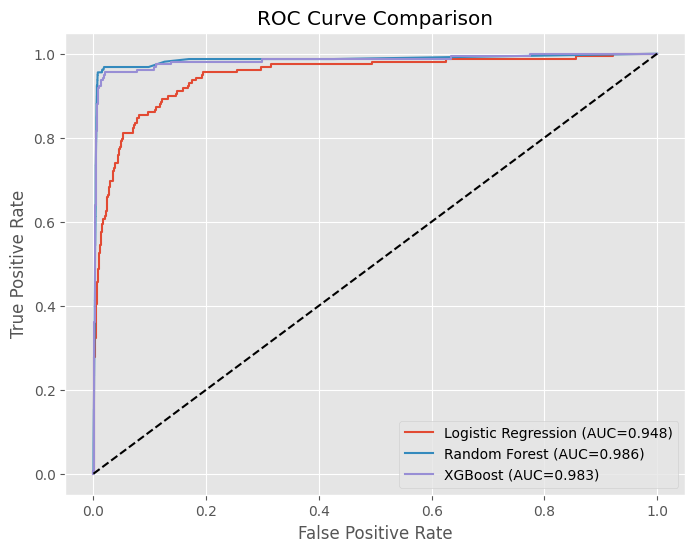

In [16]:
plt.figure(figsize=(8,6))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


##  Precision–Recall Curve

- Plots Precision vs Recall for each model  
- Displays PR-AUC score in legend  
- More informative than ROC when dealing with **class imbalance (fraud detection)**  
- Evaluates trade-off between precision and recall  


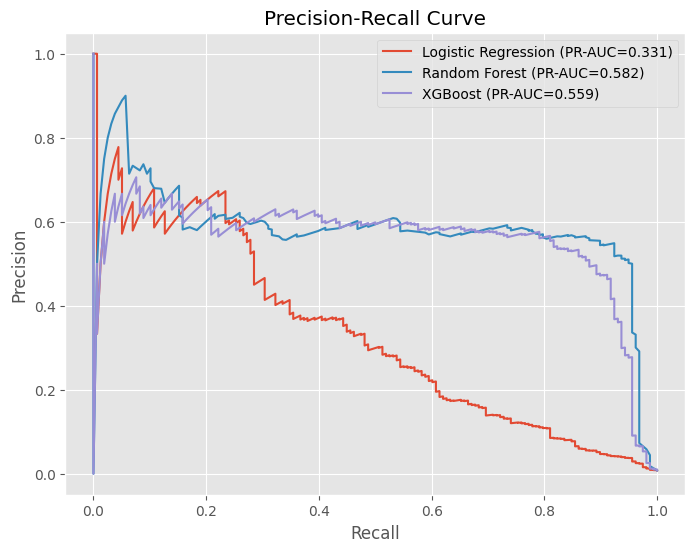

In [17]:
plt.figure(figsize=(8,6))

for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res["y_proba"])
    plt.plot(recall, precision, label=f"{name} (PR-AUC={res['pr_auc']:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


##  Best Model Selection

- Selects the model with **minimum financial loss**  
- Uses cost-sensitive evaluation (FN & FP costs)  
- Prints best-performing model and its total loss  


In [18]:
best_model_name = min(results, key=lambda x: results[x]["loss"])
best_model = results[best_model_name]["model"]

print("Best Model Based on Financial Loss:", best_model_name)
print("Loss:", results[best_model_name]["loss"])


Best Model Based on Financial Loss: XGBoost
Loss: 183800
